In [28]:
audioFile = "./data/01_港语.wav"
# audioFile = './data/hey_xpeng/hey_xpeng_04.wav'

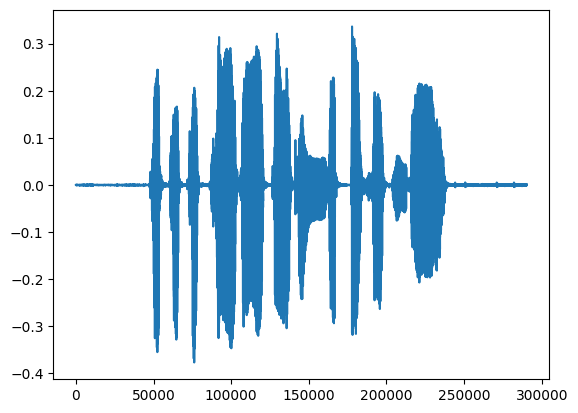

In [29]:
from utils import read_wav, to_numpy
sound, ys = read_wav(audioFile)

StatOutput = {
    "fName": audioFile,
    "sampRate": sound.frame_rate, #采样率
    "sampBits": sound.sample_width * 8, #采样位宽
    "numChan": sound.channels,
    "chanNum": "0",
    "numSamp": ys.shape[0],#单一声道的采样点数
}

import matplotlib.pyplot as plt
plt.plot(ys)
plt.show()

from IPython.display import display, Audio
display(Audio(data=ys, rate=sound.frame_rate))

### Calculate some general stats

In [30]:
from math import pow
import numpy as np

inWavVec= ys
posPeak = np.max(inWavVec, axis=0)
negPeak = np.min(inWavVec, axis=0)
absPeak = np.max(np.abs(inWavVec), axis=0)

floatToIntScalingFactor = pow(2, StatOutput["sampBits"] - 1)
intPosPeak = posPeak * floatToIntScalingFactor
intNegPeak = negPeak * floatToIntScalingFactor
intAbsPeak = absPeak * floatToIntScalingFactor

In [31]:
from math import sqrt

meanPow = np.mean(np.square(inWavVec), axis=0)
dcOffset = np.mean(inWavVec, axis=0)
print("meanPow", meanPow)
print("dcOffset", dcOffset)

meanPow 0.0034415511881628847
dcOffset -1.2632098717946234e-05


### Do block-based processing

In [32]:
def clamp(val, lower, upper):
    return max(lower, min(val, upper))

def millisecToSamples(milliSec, sampleRate):
    return milliSec / 1000 * sampleRate

def samplesToMillisec(samples, sampleRate):
    return samples * 1000 / sampleRate

# block
stepSizeMs = 10
blockToStepRatio = 1

stepSizeSamp = millisecToSamples(stepSizeMs, StatOutput["sampRate"])
stepSizeSamp = clamp(stepSizeSamp, stepSizeSamp, StatOutput["numSamp"])

actualStepSizeMs = samplesToMillisec(stepSizeSamp, StatOutput["sampRate"])

# smooth length
smoothLen = 10

# floor multiplier and enforce bounds
MINIMUM_DB = -192.0
MAXIMUM_DB = 192.0

#### Calculate block-power vector

In [33]:
import math

import numpy as np


class BlockIndexer(object):
    def __init__(
        self,
        dataSize: int,
        stepSize: int,
        blockToStepRatio: int,
        omitEndBlockIfIncomplete: bool,
        inReverseOrder: bool,
    ):
        self.dataSize = dataSize
        self.currentBlockNum = 0
        self.startIndexVec = np.nan
        self.endIndexVec = np.nan

        assert dataSize >= 1, "dataSize < 1"
        assert blockToStepRatio >= 1, "blockToStepRatio < 1"

        blockSize = min(stepSize * blockToStepRatio, dataSize)

        if omitEndBlockIfIncomplete:
            numBlocks = math.floor((dataSize - blockSize) / stepSize) + 1
            assert (
                numBlocks > 1
            ), "we have 'omitEndBlockIfIncomplete' and blockSize is larger than file"
        else:
            numBlocks = math.ceil(dataSize / stepSize)

        if inReverseOrder:
            self.endIndexVec = (
                dataSize
                - 1
                - np.linspace(0, stepSize * (numBlocks - 1), numBlocks, dtype=np.int32)
            )
            self.startIndexVec = np.clip(
                self.endIndexVec - blockSize + 1, 0, dataSize - 1
            ).astype(
                int
            )  # 每start和end之间是一个block
        else:
            self.startIndexVec = np.linspace(
                0, stepSize * (numBlocks - 1), numBlocks, dtype=np.int32
            )
            self.endIndexVec = np.clip(
                self.startIndexVec + blockSize - 1, 0, dataSize - 1
            ).astype(int)

    def getNumBlocks(self):
        return self.startIndexVec.shape[0]

    def getStartIndex(self):
        return self.startIndexVec[self.currentBlockNum]

    def getEndIndex(self):
        return self.endIndexVec[self.currentBlockNum]

    def incrementBlock(self) -> bool:
        if self.currentBlockNum < self.getNumBlocks() - 1:
            self.currentBlockNum += 1
            return True
        else:
            return False


def calcFuncBlockVector(
    funcName: str,
    inVec: np.ndarray,
    stepSize: int,
    blockToStepRatio: int,
    omitEndBlockIfIncomplete: bool,
    inReverseOrder: bool,
):
    bi = BlockIndexer(
        len(inVec), stepSize, blockToStepRatio, omitEndBlockIfIncomplete, inReverseOrder
    )
    outVec = np.empty(bi.getNumBlocks(), dtype=np.float64)

    while True:
        inVec_block = inVec[bi.getStartIndex() : bi.getEndIndex() + 1]
        if funcName == "mean-square":
            outVec[bi.currentBlockNum] = np.mean(np.square(inVec_block))
        elif funcName == "mean":
            outVec[bi.currentBlockNum] = np.mean(inVec_block)
        elif funcName == "median":
            outVec[bi.currentBlockNum] = np.median(inVec_block)
        elif funcName == "stddev":
            outVec[bi.currentBlockNum] = np.std(inVec_block)
        elif funcName == "min":
            outVec[bi.currentBlockNum] = np.min(inVec_block)
        elif funcName == "max":
            outVec[bi.currentBlockNum] = np.max(inVec_block)
        else:
            raise ValueError(f"calcFuncBlockVector: Unknown func-name {funcName}")

        if not bi.incrementBlock():
            break
    return outVec

In [34]:
# calculate power by block
powVec = calcFuncBlockVector(
    "mean-square", inWavVec, stepSizeSamp, blockToStepRatio, False, False
)

In [35]:
# convert to db(add low-floor to avoid -inf)
def ratio_to_dB(inVec: np.ndarray):
    return 10 * np.log10(np.abs(inVec) + 1e-12)

In [36]:
# do smoothing by convolution
convDbVec = ratio_to_dB(
    np.convolve(powVec, np.ones(smoothLen) / smoothLen, mode="same")
)

In [37]:
# Get min and max stats before setting floor-ratio etc
maxConvPowDb = clamp(np.max(convDbVec), MINIMUM_DB, MAXIMUM_DB)
minConvPowDb = clamp(np.min(convDbVec), MINIMUM_DB, MAXIMUM_DB)

In [38]:
# Set a floor (avoid -Inf)
floorRatioDb = -50.0
floorRatioDb = clamp(floorRatioDb, MINIMUM_DB, -5.0)

floorDb = np.max(convDbVec) + floorRatioDb
convDbVec = np.clip(convDbVec, a_min=floorDb, a_max=np.max(convDbVec))

In [39]:
# Calculate high/low signal levels
minVec = calcFuncBlockVector(
    "min",
    convDbVec,
    stepSize=10,
    blockToStepRatio=100,
    omitEndBlockIfIncomplete=False,
    inReverseOrder=False,
)
maxVec = calcFuncBlockVector(
    "max",
    convDbVec,
    stepSize=10,
    blockToStepRatio=100,
    omitEndBlockIfIncomplete=False,
    inReverseOrder=False,
)

In [40]:
# Do a 'wide-median' for the min and max vectors
def wideMedian(inVec: np.ndarray, proportion: float):
    vec = np.sort(inVec)
    idx1 = int((1 - abs(proportion)) * (len(vec) - 1) / 2)
    idx2 = int((1 + abs(proportion)) * (len(vec) - 1) / 2)
    return np.mean(vec[idx1 : idx2 + 1])


lowLevel = wideMedian(minVec, 0.5)
highLevel = wideMedian(maxVec, 0.5)

In [41]:
# Check if low / high above have been skewed by unusual signals (eg. short impulses)
lowLevel = min(np.min(minVec) / 2 + np.max(minVec) / 2, lowLevel)
highLevel = max(np.min(maxVec) / 2 + np.max(maxVec) / 2, highLevel)

In [42]:
# Calc a threshold for signal
mixProportion = 0.6
sigThreshDb = mixProportion * lowLevel + (1 - mixProportion) * highLevel

In [43]:
# Extra floor safety step
convDbVec = np.where(convDbVec < lowLevel - 3, lowLevel - 3, convDbVec)

In [44]:
# Refine high/low values
sigMeanPow = highLevel
bkgMeanPow = lowLevel
aWeightSigMeanPow = highLevel
aWeightBkgMeanPow = lowLevel
startIdx = 0
endIdx = len(powVec) - 1
altPeaksVal = absPeak
avPeaksVal = absPeak

In [45]:
class VectorLevels:
    def __init__(self, initialMidLevel, highWeight, numLoops):
        self.midInitial = initialMidLevel
        self.w = highWeight
        self.loops = numLoops

        self.highLevel = None
        self.midLevel = None
        self.lowLevel = None

    def getHighLevel(self):
        return self.highLevel

    def getMidLevel(self):
        return self.midLevel

    def getLowLevel(self):
        return self.lowLevel

    def getHighMidLevel(self):
        return 0.5 * self.highLevel + 0.5 * self.midLevel

    def getLowMidLevel(self):
        return 0.5 * self.lowLevel + 0.5 * self.midLevel

    def calculate(self, inVec: np.ndarray):
        self.midLevel = self.midInitial
        wideMedianProportion = 0.7
        for i in range(self.loops):
            self.lowLevel = wideMedian(
                inVec[inVec < self.midLevel], wideMedianProportion
            )
            self.highLevel = wideMedian(
                inVec[inVec > self.midLevel], wideMedianProportion
            )
            self.midLevel = (1 - self.w) * self.lowLevel + self.w * self.highLevel

In [46]:
# Only check if data has enough dynamic range

minHiLowDiff = 1
if highLevel - lowLevel > minHiLowDiff:
    # Work out an alternate peak value (experimental - to avoid one off peak/bumps etc)
    peaksVec = calcFuncBlockVector(
        "max", np.abs(inWavVec), stepSizeSamp, blockToStepRatio, False, False
    )

    # Peaks for above-thresh frames
    tmpVec = np.abs(np.sort(-peaksVec[convDbVec > sigThreshDb]))

    # Get mean of top peaks
    num_of_top_elem = max(1, int(len(tmpVec) / 20))
    altPeaksVal = np.mean(tmpVec[:num_of_top_elem])

    # Get mean of all above-thresh peaks
    avPeaksVal = np.mean(tmpVec)

    lvls = VectorLevels(sigThreshDb, 1 - mixProportion, 3)
    lvls.calculate(convDbVec)
    highLevel = lvls.getHighLevel()
    sigThreshDb = lvls.getMidLevel()
    lowLevel = lvls.getLowLevel()

    # Calculate mean-pow of sig and background sections
    filter_db = 0.25 * highLevel + 0.75 * sigThreshDb
    filter_idx = np.where(convDbVec > filter_db)[0]
    sigMeanPow = np.mean(powVec[filter_idx])

    filter_db = sigThreshDb
    filter_idx = np.where(convDbVec < filter_db)[0]
    bkgMeanPow = wideMedian(powVec[filter_idx], 0.75)

### 函数 scipy.signal.butter(N, Wn, btype='low', analog=False, output='ba')
+ 输入参数：
    - N:滤波器的阶数
    - Wn：归一化截止频率。计算公式Wn=2*截止频率/采样频率。（注意：根据采样定理，采样频率要大于两倍的信号本身最大的频率，才能还原信号。截止频率一定小于信号本身最大的频率，所以Wn一定在0和1之间）。当构造带通滤波器或者带阻滤波器时，Wn为长度为2的列表。
    - btype : 滤波器类型{‘lowpass', ‘highpass', ‘bandpass', ‘bandstop'},
    - output : 输出类型{‘ba', ‘zpk', ‘sos'},
+ 输出参数：
    - b，a: IIR滤波器的分子（b）和分母（a）多项式系数向量。output='ba'
    - z,p,k: IIR滤波器传递函数的零点、极点和系统增益. output= 'zpk'
    - sos: IIR滤波器的二阶截面表示。output= 'sos'

In [72]:
from math import pow

from scipy.signal import butter, filtfilt


class bandPassFilter:
    def __init__(self, lowcut, highcut, samprate, order):
        lowcut = lowcut / samprate
        highcut = highcut / samprate
        self.b, self.a = butter(order, [lowcut, highcut], btype="bandpass")

    def filter(self, inWav: np.array):
        return filtfilt(self.b, self.a, inWav)


class highPassFilter:
    def __init__(self, highcut, samprate, order):
        highcut = highcut / samprate
        self.b, self.a = butter(order, highcut, btype="highpass")

    def filter(self, inWav: np.array):
        return filtfilt(self.b, self.a, inWav)


def dbToRms(dbVal):
    return pow(10, dbVal / 20.0)

def dbToPow(dbVal):
    return pow(10, dbVal / 10.0)


def runDspAWeight(inVec: np.array, sampleRate):
    gainDb = 1.40
    gain = dbToRms(gainDb)
    # hpf
    hpf = highPassFilter(27, sampleRate, order=2)
    inVec_1 = hpf.filter(inVec) * gain

    # bpf1 frequency vector
    bpf1 = bandPassFilter(640, 9300, sampleRate, order=1)
    inVec_2 = bpf1.filter(inVec_1)

    # bpf2 frequency vector
    bpf2 = bandPassFilter(123, 15500, sampleRate, order=1)
    inVec_3 = bpf2.filter(inVec_2)

    return inVec_3

In [71]:
# Calculate vars for A-weighted SNR
sampleRate = StatOutput.get("sampRate")
filtWavVec = runDspAWeight(inWavVec, sampleRate)  # 这一步的滤波器截止频率高于2倍音频采样率
aWeightPowVec = calcFuncBlockVector(
    "mean-square", filtWavVec, stepSizeSamp, blockToStepRatio, False, False
)

In [49]:
# Sig & background levels for A-weight vec
filter_db = 0.25 * highLevel + 0.75 * sigThreshDb
filter_idx = np.where(convDbVec > filter_db)[0]
aWeightSigMeanPow = wideMedian(aWeightPowVec[filter_idx], 0.75)

filter_db = sigThreshDb
filter_idx = np.where(convDbVec < filter_db)[0]
aWeightBkgMeanPow = wideMedian(aWeightPowVec[filter_idx], 0.75)

In [50]:
# Combo vec(for endpoints calcs)
awCombineProportion = 0.5
comboSmoothLen = 15

# triWindow
triWindowVec = np.bartlett(comboSmoothLen)
comboSmoothVec = triWindowVec / np.sum(triWindowVec)

comboLinVec = (1 - awCombineProportion) * powVec + awCombineProportion * aWeightPowVec
nonZerosIdxVec = np.where(powVec > 0)[0]
comboLinVec = np.convolve(comboLinVec, comboSmoothVec, mode="same")
comboDbVec = ratio_to_dB(comboLinVec)
comboFloorRatioDb = -80.0
comboDbVec = np.clip(comboDbVec, a_min=np.max(comboDbVec)+comboFloorRatioDb, a_max=np.max(comboDbVec))

In [51]:
comboLvls = VectorLevels(np.mean(comboDbVec[nonZerosIdxVec]), 0.5, 4)
nonZerosProportion = float(nonZerosIdxVec.shape[0]) / float(comboDbVec.shape[0])
if nonZerosProportion < 0.9 and nonZerosProportion > 0:
    comboLvls.calculate(comboDbVec[nonZerosIdxVec])
    # new floor in linear domain
    comboLinVec += dbToPow(comboLvls.getLowLevel())
    comboDbVec = ratio_to_dB(comboLinVec)

comboLvls = VectorLevels(np.mean(comboDbVec), 0.5, 4)
comboLvls.calculate(comboDbVec)

In [109]:
from scipy.signal import medfilt
# do median-filter stuff
medianFiltLen = 17

# sum in linear domain
comboMedFiltLinVec = (1-awCombineProportion) * medfilt(powVec, medianFiltLen) + awCombineProportion * medfilt(aWeightPowVec, medianFiltLen)

comboMedFiltDbVec = ratio_to_dB(comboMedFiltLinVec)
comboMedFiltDbVec = np.clip(comboMedFiltDbVec, a_min=np.max(comboMedFiltDbVec)+comboFloorRatioDb, a_max=np.max(comboMedFiltDbVec))

comboMedFiltLvls = VectorLevels(0.5*np.median(comboMedFiltDbVec)+0.25*np.max(comboMedFiltDbVec)+0.25*max(np.min(comboMedFiltDbVec), np.max(comboMedFiltDbVec)-20.0), 0.5, 4)
comboMedFiltLvls.calculate(comboMedFiltDbVec)

# find endpoints from combo vector
aboveHighMidIdxVec = np.where(comboMedFiltDbVec > comboMedFiltLvls.getHighMidLevel())[0]
# belowLowMidIdxVec = np.where(comboDbVec > comboLvls.getLowMidLevel())[0]
# belowLowIdxVec = np.where(comboDbVec > comboLvls.getLowLevel())[0]
belowLowMidIdxVec = np.where(comboDbVec < comboLvls.getLowMidLevel())[0]
belowLowIdxVec = np.where(comboDbVec <= comboLvls.getLowLevel())[0]

In [110]:
# First calc (start higher)
startIdx = aboveHighMidIdxVec[0]
endIdx = aboveHighMidIdxVec[-1]
print(startIdx)
print(endIdx)

102
493


sigThreshCombo = -56.260876159012
startIdx = 93
endIdx = 501


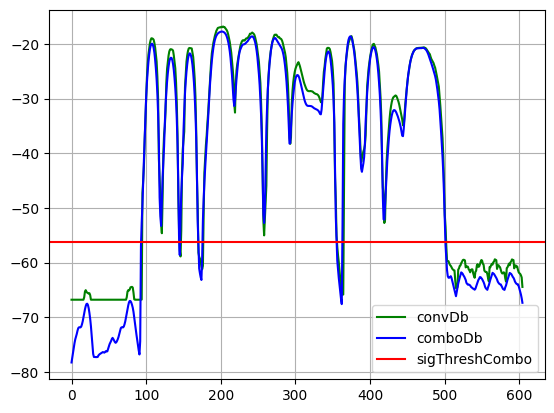

In [111]:
# adjust by roll out to low-mid thresh
startRampIdxVec = np.where(belowLowMidIdxVec<startIdx)[0]
if startRampIdxVec.ndim == 1 and startRampIdxVec.size > 0:
    startIdx = belowLowMidIdxVec[startRampIdxVec[-1]]

endRampIdxVec =np.where(belowLowMidIdxVec>endIdx)[0]
if endRampIdxVec.ndim == 1 and endRampIdxVec.size > 0:
    endIdx = belowLowMidIdxVec[endRampIdxVec[0]]

# extra ramp-out (just to allow for a not-so-steep trailing edge)
end2RampIdxVec = np.where(belowLowIdxVec>endIdx)[0]
if end2RampIdxVec.ndim == 1 and abs(end2RampIdxVec[0] - endIdx) < 5:
    endIdx = belowLowIdxVec[end2RampIdxVec[0]]

assert startIdx < endIdx

print(f"sigThreshCombo = {comboLvls.getLowMidLevel()}")
print(f"startIdx = {startIdx}")
print(f"endIdx = {endIdx}")
plt.plot(convDbVec, color='g', label='convDb')
plt.plot(comboDbVec, color='b', label='comboDb')
plt.axhline(comboLvls.getLowMidLevel(), color='r', label='sigThreshCombo')
plt.legend()
plt.grid()
plt.show()

In [112]:
# calculate saturation stats
peakIndexVec = np.where((inWavVec >= posPeak) | (inWavVec <= negPeak))[0]
peakRangeVec = np.diff(peakIndexVec)

numPkRuns = peakRangeVec[peakRangeVec>1].shape[0] + 1
pkRunAvLen = peakIndexVec.shape[0] / numPkRuns

In [113]:
# calculate zero-run stats
zeroIdxVec = np.where(inWavVec == 0)[0] #Indices of zero-samples
if zeroIdxVec.ndim == 1 and zeroIdxVec.size > 0:
    zeroRangeVec = np.diff(zeroIdxVec)
    breakIdxVec = np.where(zeroRangeVec>1)[0] #Indices of breaks in the zero-run
    zerosRunLenVec = np.zeros(breakIdxVec.size+1)
    if breakIdxVec.ndim == 1 and breakIdxVec.size > 0:
        # length of first zero-run
        zerosRunLenVec[0] = breakIdxVec[0] + 1
        # length of last zero-run
        zerosRunLenVec[-1] = zeroIdxVec.size - breakIdxVec[-1] - 1
        if zerosRunLenVec.size > 2:
            zerosRunLenVec[1:-1] = np.diff(breakIdxVec)
    else:
        # length of first zero-run
        zerosRunLenVec[0] = zeroIdxVec.size
else:
    # if we didn't get anything in first vector, just have a zero here...
    zerosRunLenVec = np.array([0])

In [114]:
# Convert time vars from steps to seconds(0.5 offset for 'middle of block')
startSilSec = (startIdx + 0.5) * float(stepSizeSamp) / float(sampleRate)
endSpSec = (endIdx + 0.5) * float(stepSizeSamp) / float(sampleRate)
numSec = float(inWavVec.size) / float(sampleRate)
endSilSec = max(numSec - endSpSec, 0.0)

In [115]:
# Threshold-related stats
numBlocksOverThresh = np.count_nonzero(convDbVec > sigThreshDb)
numBlocksUnderThresh = np.count_nonzero(convDbVec <= sigThreshDb)
sigRatio = float(numBlocksOverThresh) / float(convDbVec.size)
sigSec = float(numBlocksOverThresh) * actualStepSizeMs / 1000.0
bkgSec = float(numSec) - sigSec

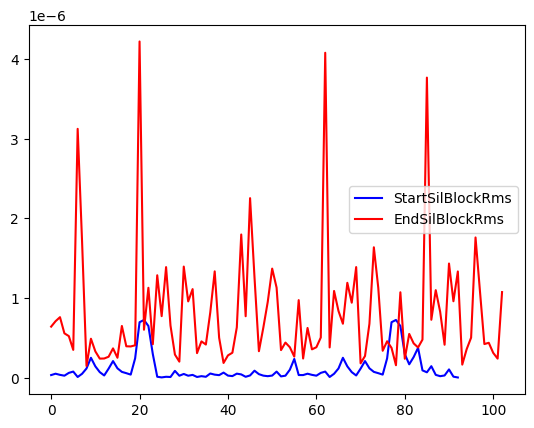

In [116]:
# Get info about level in start and end silence parts
StartSilBlockRms = powVec[:max(startIdx, 1)]
EndSilBlockRms = powVec[-max(powVec.size - endIdx - 1, 1):]
maxStartSilBlockRms = np.max(StartSilBlockRms)
maxEndSilBlockRms = np.max(EndSilBlockRms)
plt.plot(StartSilBlockRms, color='b',label='StartSilBlockRms')
plt.plot(EndSilBlockRms, color='r',label='EndSilBlockRms')
plt.legend()
plt.show()

In [117]:
# Do soft-clipping estimation 失真度量


In [118]:
from math import pow

from scipy.signal import butter, filtfilt


class highPassFilter:
    """一阶高通滤波器，截止频率"""
    def __init__(self, lowcut, samprate, order):
        cutoff = lowcut / samprate
        self.b, self.a = butter(order, cutoff, btype="highpass")

    def filter(self, inWav: np.array):
        return filtfilt(self.b, self.a, inWav)


class highShelfFilter:
    
    def __init__(self, cutoff, samprate, gain, order):
        shelfslope=0.1 # passband ripple 0.1dB
        A = pow(10, gain/40)
        omega = 2*np.pi*cutoff/samprate
        cs = np.cos(omega)
        sn = np.sin(omega)
        AL = sn / 2 * np.sqrt((A+1/A)*(1/shelfslope - 1)+2)
        sq = 2*sqrt(A) * AL
        b0 = A*((A+1)+(A-1)*cs+sq)
        b1 = -2*A*((A-1)+(A+1)*cs)
        b2 = A*((A+1)+(A-1)*cs-sq)
        a0 = (A+1)-(A-1)*cs+sq
        a1 = 2*((A-1)-(A+1)*cs)
        a2 = (A+1)-(A-1)*cs-sq
        self.b = np.array([b0,b1,b2])
        self.a = np.array([a0,a1,a2])
        # print(self.b)
        # print(self.a)

    def filter(self, inWav: np.array):
        return filtfilt(self.b, self.a, inWav)


def dbToRms(dbVal):
    return pow(10, dbVal / 20.0)

def dbToPow(dbVal):
    return pow(10, dbVal / 10.0)


def runDspKWeight(inVec: np.array, sampleRate):
    correctionGain=1.00411
    
    # do the highpass part
    hpf = highPassFilter(38.14, sampleRate, order=1)
    inVec_1 = correctionGain * hpf.filter(inVec)
    
    # do the high-shelf part
    hsf = highShelfFilter(1500, sampleRate, 4.0, order=2)
    inVec_2 = hsf.filter(inVec_1)
    
    stepSizeMs = 100
    blockToStepRatio = 4
    stepSizeSamp = stepSizeMs
    
    stepSizeSamp = millisecToSamples(stepSizeMs, StatOutput["sampRate"])
    stepSizeSamp = clamp(stepSizeSamp, stepSizeSamp, StatOutput["numSamp"])
    
    # k-weight power vector
    kWeightPowVec = calcFuncBlockVector(
    "mean-square", inVec_2, stepSizeSamp, blockToStepRatio, True, False
    )
    return kWeightPowVec

In [119]:
def rmsToDb(linVal):
    return max(2*ratio_to_dB(linVal), MINIMUM_DB)
def powToDb(linVal):
    return max(ratio_to_dB(linVal), MINIMUM_DB)

In [120]:
# Do LUFS calculation LUFS响度量值
kWeightPowVec = runDspKWeight(inWavVec, sampleRate)

meanPowDbK = powToDb(np.mean(kWeightPowVec))
maxBlockDbK = powToDb(np.max(kWeightPowVec))
minBlockDbK = powToDb(np.min(kWeightPowVec))

In [121]:
# Calculate the lkfs values
lkfsVec = -0.691 + ratio_to_dB(kWeightPowVec)
absThreshDbK = -70.0
aboveAbsIdx = np.where(lkfsVec > absThreshDbK)[0]
relThreshDbK= -np.inf
gatedLoudnessDbK = -np.inf
if aboveAbsIdx.ndim==1 and aboveAbsIdx.size>0:
    relThreshDbK = -0.691 + ratio_to_dB(np.mean(kWeightPowVec[aboveAbsIdx]))
    # relThreshDbK = -0.691 + ratio_to_dB(wideMedian(kWeightPowVec[aboveAbsIdx], 0.5))
    
    aboveBothIdx=np.where(lkfsVec > max(absThreshDbK, relThreshDbK))[0]
    if aboveBothIdx.ndim==1 and aboveBothIdx.size>0:
        gatedLoudnessDbK = -0.691 + ratio_to_dB(np.mean(kWeightPowVec[aboveBothIdx]))
        # gatedLoudnessDbK = -0.691 + ratio_to_dB(wideMedian(kWeightPowVec[aboveBothIdx], 0.5))

In [122]:
StatOutput['blockSizeMs'] = stepSizeMs*blockToStepRatio
StatOutput['smoothLen'] = smoothLen
StatOutput['numSec'] = numSec
StatOutput['sigSec'] = sigSec
StatOutput['bkgSec'] = bkgSec
StatOutput['sigRatio'] =sigRatio
StatOutput['startSilSec'] =startSilSec
StatOutput['endSilSec'] =endSilSec
StatOutput['endSpSec'] =endSpSec
StatOutput['dcOffsetdB'] = rmsToDb(dcOffset)
StatOutput['meanPowdB'] = powToDb(meanPow)
StatOutput['lufsdBK'] = gatedLoudnessDbK
StatOutput['maxBlockPowdB'] = powToDb(np.max(powVec))
StatOutput['minBlockPowdB'] = powToDb(np.min(powVec))
StatOutput['blockRangedB']= powToDb(np.max(powVec)) - powToDb(np.min(powVec))
StatOutput['medBlockPowdB']= powToDb(np.median(powVec))
StatOutput['stdBlockPowdB']= powToDb(np.std(powVec))
StatOutput['maxConvPowdB']= maxConvPowDb
StatOutput['minConvPowdB']= minConvPowDb
StatOutput['convRangedB']=maxConvPowDb-minConvPowDb
StatOutput['sigRmsdB'] = powToDb(sigMeanPow)
StatOutput['sigRmsdBA'] = powToDb(aWeightSigMeanPow)
StatOutput['bkgRmsdB']=powToDb(bkgMeanPow)
StatOutput['bkgRmsdBA']=powToDb(aWeightBkgMeanPow)
StatOutput['sigThreshdB']=sigThreshDb
StatOutput['SNRdB']= powToDb(sigMeanPow) - powToDb(bkgMeanPow)
StatOutput['SNRdBA']=powToDb(aWeightSigMeanPow)-powToDb(aWeightBkgMeanPow)
StatOutput['startPowdB']=powToDb(np.mean(powVec[:min(powVec.size, smoothLen)]))
StatOutput['endPowdB']=powToDb(np.mean(powVec[-min(powVec.size, smoothLen):]))
StatOutput['maxStSilBlkdB']=powToDb(maxStartSilBlockRms)
StatOutput['maxEdSilBlkdB']=powToDb(maxEndSilBlockRms)
StatOutput['posPeakInt']=intPosPeak
StatOutput['negPeakInt']=intNegPeak
StatOutput['absPeakInt']=intAbsPeak
StatOutput['absPeakPercent']=100.0*absPeak
StatOutput['absPeakdB'] = rmsToDb(absPeak)
StatOutput['altPeakdB'] = rmsToDb(altPeaksVal)
StatOutput['avPeakdB'] = rmsToDb(avPeaksVal)
StatOutput['numPeaks'] = peakIndexVec.size
StatOutput['numPkRuns'] = numPkRuns
StatOutput['pkRunAvLen'] = pkRunAvLen
StatOutput['numZeros'] = np.sum(zerosRunLenVec)
StatOutput['zeroRunLenMax'] = np.max(zerosRunLenVec)
StatOutput['zeroRunLenMedian'] = np.median(zerosRunLenVec)

StatOutput

#satKur
#satCog
#satR1
#satR2

{'fName': './data/01_港语.wav',
 'sampRate': 48000,
 'sampBits': 16,
 'numChan': 1,
 'chanNum': '0',
 'numSamp': 290352,
 'blockSizeMs': 10,
 'smoothLen': 10,
 'numSec': 6.049,
 'sigSec': 3.71,
 'bkgSec': 2.3390000000000004,
 'sigRatio': 0.6132231404958678,
 'startSilSec': 0.935,
 'endSilSec': 1.0340000000000007,
 'endSpSec': 5.015,
 'dcOffsetdB': -97.97048909320793,
 'meanPowdB': -24.63245766425331,
 'lufsdBK': -19.574632619608476,
 'maxBlockPowdB': -16.218685067118702,
 'minBlockPowdB': -84.29855460292674,
 'blockRangedB': 68.07986953580804,
 'medBlockPowdB': -45.197788489955414,
 'stdBlockPowdB': -22.33670747700542,
 'maxConvPowdB': -16.799351089170926,
 'minConvPowdB': -76.6393184187943,
 'convRangedB': 59.83996732962338,
 'sigRmsdB': -22.318225327553588,
 'sigRmsdBA': -25.773416760932314,
 'bkgRmsdB': -63.92133839106534,
 'bkgRmsdBA': -74.11953881790629,
 'sigThreshdB': -47.82745996915896,
 'SNRdB': 41.603113063511756,
 'SNRdBA': 48.346122056973975,
 'startPowdB': -71.36949619436491